# Poisoning Attacks

<a target="_blank" href="https://colab.research.google.com/github/unica-mlsec/mlsec/blob/main/labs/06_poisoning_attacks.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

In this notebook, we will experiment with **adversarial poisoning attacks**. Poisoning attacks are performed at *training time* by injecting *carefully-crafted samples* that alter the classifier decision function so that its behavior at *testing time* is modified. In particular, we will analyze **backdoor** and **label-flip** attacks.

In [18]:
%%capture --no-stderr
try:
    import secmlt
except ImportError:
   %pip install secml-torch

## Backdoor Poisoning Attacks

In backdoor poisoning, the attacker acts on a subset of the training data by:
- adding a specific pattern (i.e., the **trigger**);
- modifying the label to a target class, satisfying the attacker's goal.

In this way, the model learns a correlation between the trigger and the chosen label.
As a consequence, at test time, the input samples containing the trigger will be misclassified as samples of the target class.
On the other hand, the clean samples will be correctly classified.

We will implement a simple patch-based attack against a small neural network trained on MNIST. We first code the CNN used in the paper ["BadNets: Identifying Vulnerabilities in the Machine Learning Model Supply Chain"](https://arxiv.org/pdf/1708.06733) (Gu et al., 2019).

In [19]:
import torch
import torch.nn as nn


class MNISTNet(nn.Module):

    def __init__(self):
        super().__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=16, kernel_size=5, stride=1),
            nn.ReLU(),
            nn.AvgPool2d(kernel_size=2, stride=2)
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=5, stride=1),
            nn.ReLU(),
            nn.AvgPool2d(kernel_size=2, stride=2)
        )
        self.fc1 = nn.Sequential(
            nn.Linear(in_features=512, out_features=512),
            nn.ReLU()
        )
        self.fc2 = nn.Sequential(
            nn.Linear(in_features=512, out_features=10),
            nn.Softmax(dim=-1)
        )

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        x = self.fc2(x)
        return x

In [20]:
device = "cuda"
net = MNISTNet()
net.to(device)

MNISTNet(
  (conv1): Sequential(
    (0): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1))
    (1): ReLU()
    (2): AvgPool2d(kernel_size=2, stride=2, padding=0)
  )
  (conv2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1))
    (1): ReLU()
    (2): AvgPool2d(kernel_size=2, stride=2, padding=0)
  )
  (fc1): Sequential(
    (0): Linear(in_features=512, out_features=512, bias=True)
    (1): ReLU()
  )
  (fc2): Sequential(
    (0): Linear(in_features=512, out_features=10, bias=True)
    (1): Softmax(dim=-1)
  )
)

We then load the MNIST training dataset from the TorchVision datasets hub.

In [21]:
%%capture
import torchvision


dataset_path = "data/datasets/"

training_dataset = torchvision.datasets.MNIST(
    transform=torchvision.transforms.ToTensor(),
    train=True,
    root=dataset_path,
    download=True,
)

We now need a function to inject the backdoor. In particular, we will apply a white 4x4 patch in the bottom-right corner of the images.

In [22]:
def apply_patch(x: torch.Tensor) -> torch.Tensor:
    x[:, 0, 24:28, 24:28] = 1.0
    return x

We can now create our poisoned dataset loader.

The `BackdookDatasetPytorch` class of SecML-Torch is a custom PyTorch dataset that applies the backdoor through a custom function on a certain amount of the training data, also switching their labels to the desired target label. We set the portion of the manipulated training samples to 10%.

The backdoored dataset can thus be wrapped into a PyTorch `DataLoader`, and used for training the neural network.

In [23]:
from secmlt.adv.poisoning.backdoor import BackdoorDatasetPyTorch
from torch.utils.data import DataLoader


target_label = 1
backdoored_mnist = BackdoorDatasetPyTorch(
    training_dataset,
    data_manipulation_func=apply_patch,
    trigger_label=target_label,
    portion=0.1,
)
training_data_loader = DataLoader(backdoored_mnist, batch_size=64, shuffle=False)

Let's visualize some of the training images!

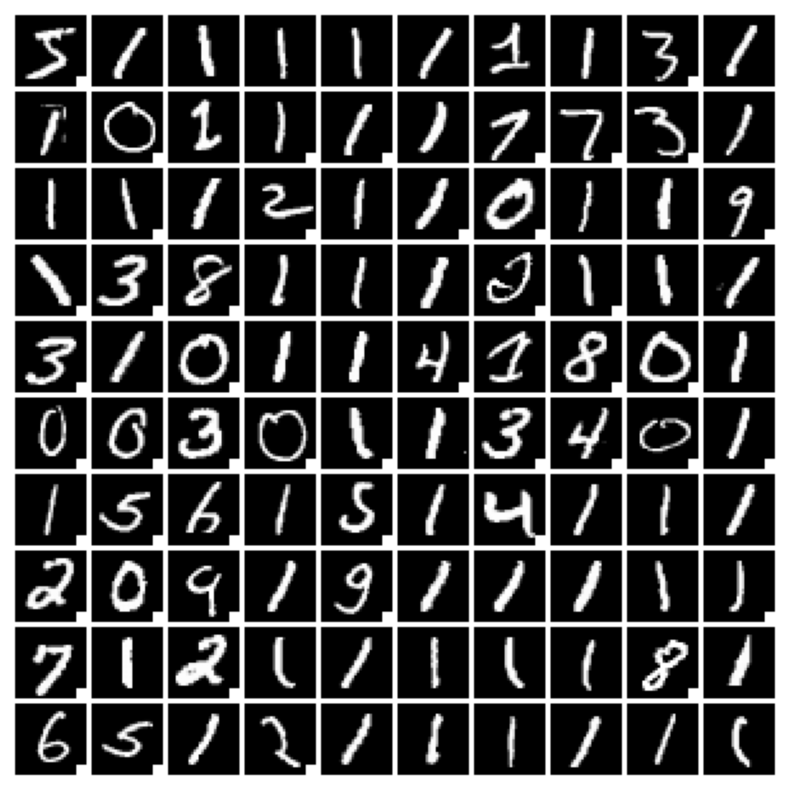

In [24]:
import matplotlib.pyplot as plt
from torchvision.utils import make_grid


x_target = []
for x, y in training_data_loader:
    x_target.append(x[y == target_label])
x_target = torch.cat(x_target, dim=0)

grid = make_grid(x_target[:100], nrow=10, normalize=True, pad_value=1.0)
plt.figure(figsize=(10, 10))
plt.imshow(grid.permute(1, 2, 0).cpu())
plt.axis("off")
plt.show()

To train the model, we leverage the SecML-Torch utils, so that we have to instantiate:
- a PyTorch optimizer, passing the network parameters;
- a `BasePyTorchTrainer`, passing the optimizer and the number of epochs;
- a `BasePytorchClassifier`, wrapping the network and the trainer.

Finally, we only need to call the `BasePytorchClassifier.train` method, providing the training data loader.

In [25]:
from torch.optim import Adam
from secmlt.models.pytorch.base_pytorch_nn import BasePytorchClassifier
from secmlt.models.pytorch.base_pytorch_trainer import BasePyTorchTrainer


optimizer = Adam(lr=1e-3, params=net.parameters())
trainer = BasePyTorchTrainer(optimizer, epochs=5)
model = BasePytorchClassifier(net, trainer=trainer)
model.train(training_data_loader)

MNISTNet(
  (conv1): Sequential(
    (0): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1))
    (1): ReLU()
    (2): AvgPool2d(kernel_size=2, stride=2, padding=0)
  )
  (conv2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1))
    (1): ReLU()
    (2): AvgPool2d(kernel_size=2, stride=2, padding=0)
  )
  (fc1): Sequential(
    (0): Linear(in_features=512, out_features=512, bias=True)
    (1): ReLU()
  )
  (fc2): Sequential(
    (0): Linear(in_features=512, out_features=10, bias=True)
    (1): Softmax(dim=-1)
  )
)

We can now load the MNIST test data and wrap it into a PyTorch `DataLoader`.

In [26]:
%%capture
test_dataset = torchvision.datasets.MNIST(
    transform=torchvision.transforms.ToTensor(),
    train=False,
    root=dataset_path,
    download=True,
)
test_data_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

First, we test the accuracy on the clean test data.

In [27]:
from secmlt.metrics.classification import Accuracy


accuracy = Accuracy()(model, test_data_loader)
print("test accuracy: ", accuracy)

test accuracy:  tensor(0.9878)


We then wrap the test dataset into the `BackdoorDatasetPyTorch`, applying the trigger to all the samples, and build a new PyTorch `DataLoader` to test the model on the backdoored dataset again.

In [28]:
from secmlt.metrics.classification import AttackSuccessRate


backdoored_test_set = BackdoorDatasetPyTorch(
    test_dataset, data_manipulation_func=apply_patch
)
backdoored_loader = DataLoader(backdoored_test_set, batch_size=64, shuffle=False)

We compute the attack success rate as the fraction of backdoored samples labeled with the target class.

In [29]:
asr = AttackSuccessRate(y_target=target_label)(model, backdoored_loader)
print(f"asr: {asr}")

asr: 1.0


We can also inspect the filters of the network's first convolutional layer to see what the model has learned. In particular, we will plot the weights associated with each image region: higher values mean that the filter is more sensitive and will activate in response to corresponding patterns.

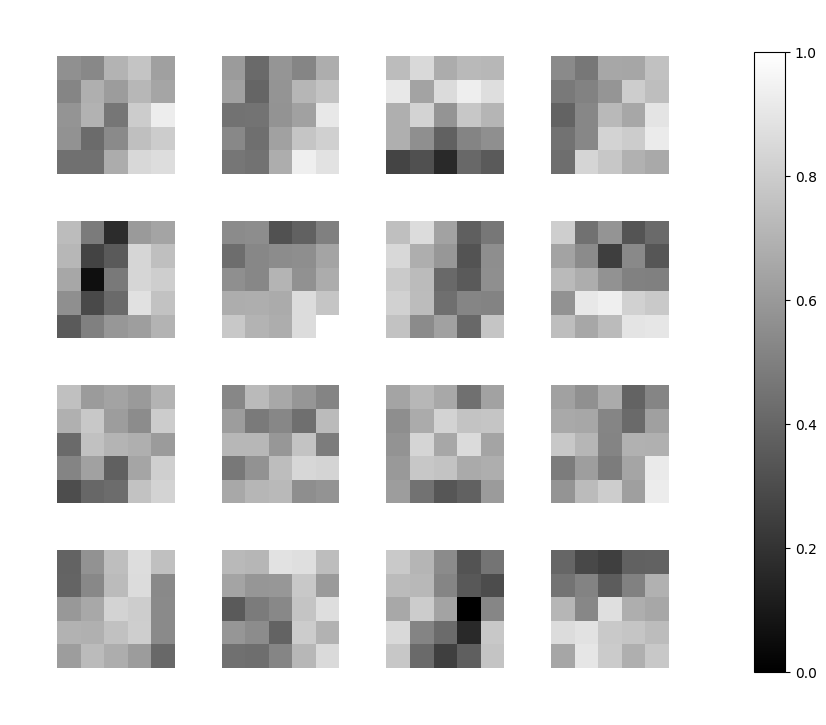

In [30]:
filters = net.conv1[0].weight.detach()
grid = make_grid(filters, nrow=4, normalize=True, pad_value=1.0)
plt.figure(figsize=(10, 10))
plt.imshow(grid.permute(1, 2, 0).cpu(), cmap="gray")
plt.axis("off")
plt.colorbar(fraction=0.04)
plt.show()

## Label-flip Poisoning Attacks

In label-flip poisoning, the attacker can only modify the labels of a training data subset to induce misclassification at test time. This can be done either randomly or based on heuristics.

We will implement the first solution, with the goal of making 0 digits classified as 1 and vice versa.

We first need a label manipulation function.

In [44]:
def flip_label(label):
    if label == 0:
        return 1
    elif label == 1:
        return 0
    return label

We can now create our poisoned dataset loader.

The `PoisoningDatasetPyTorch` class of SecML-Torch is a custom PyTorch dataset that can apply a custom manipulation function to either the inputs and/or their labels.

We want to manipulate the labels of the 50% of samples of both class 0 and 1.

The poisoned dataset can thus be wrapped into a PyTorch `DataLoader`, and used for training the neural network.

In [45]:
import random
from secmlt.adv.poisoning.base_data_poisoning import PoisoningDatasetPyTorch


class_0_idxs = [i for i, y in enumerate(training_dataset.targets) if y == 0]
class_1_idxs = [i for i, y in enumerate(training_dataset.targets) if y == 1]
poisoned_indexes = random.sample(class_0_idxs, len(class_0_idxs) // 2) + random.sample(
    class_1_idxs, len(class_1_idxs) // 2)

poisoned_mnist = PoisoningDatasetPyTorch(
    training_dataset,
    label_manipulation_func=flip_label,
    poisoned_indexes=poisoned_indexes,
)
poisoned_data_loader = DataLoader(poisoned_mnist, batch_size=64, shuffle=False)

As we want to separately inspect the model accuracy for each class, we write a function that creates a PyTorch `DataLoader` returning only the samples of a selected class.

In [46]:
from torch.utils.data import SubsetRandomSampler


def get_class_loader(label):
    idxs = [i for i, y in enumerate(test_dataset.targets) if y == label]
    test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, sampler=SubsetRandomSampler(idxs))
    return test_loader

We will now train the model on both clean and poisoned data, and evaluate it on the test dataset.

We print the total accuracy, the class accuracies, and the attack success rate for classes 0 and 1, i.e., the ratio of class 0 samples misclassified as 1 and vice versa.

In [47]:
for k, data_loader in {
    "normal": training_data_loader,
    "poisoned": poisoned_data_loader,
}.items():
    net = MNISTNet()
    net.to(device)
    optimizer = Adam(lr=1e-3, params=net.parameters())
    trainer = BasePyTorchTrainer(optimizer, epochs=5)
    model = BasePytorchClassifier(net, trainer=trainer)
    model.train(data_loader)
    accuracy = Accuracy()(model, test_data_loader)
    print(f"test accuracy on {k} data: {accuracy.item():.3f}")
    for i in range(10):
        class_test_loader = get_class_loader(i)
        accuracy = Accuracy()(model, class_test_loader)
        print(f"    test accuracy (class {i} only): {accuracy.item():.3f}")
        if i == 0 or i == 1:
            asr = AttackSuccessRate(y_target=0 if i==1 else 1)(model, class_test_loader)
            print(f"        asr on class {i}: {asr}")

test accuracy on normal data: 0.986
    test accuracy (class 0 only): 0.995
        asr on class 0: 0.0010204081190750003
    test accuracy (class 1 only): 0.996
        asr on class 1: 0.0008810572908259928
    test accuracy (class 2 only): 0.991
    test accuracy (class 3 only): 0.984
    test accuracy (class 4 only): 0.985
    test accuracy (class 5 only): 0.985
    test accuracy (class 6 only): 0.984
    test accuracy (class 7 only): 0.977
    test accuracy (class 8 only): 0.982
    test accuracy (class 9 only): 0.975
test accuracy on poisoned data: 0.779
    test accuracy (class 0 only): 0.000
        asr on class 0: 0.9979591965675354
    test accuracy (class 1 only): 0.041
        asr on class 1: 0.9550660848617554
    test accuracy (class 2 only): 0.986
    test accuracy (class 3 only): 0.982
    test accuracy (class 4 only): 0.998
    test accuracy (class 5 only): 0.984
    test accuracy (class 6 only): 0.977
    test accuracy (class 7 only): 0.986
    test accuracy (class 8 o